# <font color='green'>Logistic regression</font>

DATA: Kaggle -> Titanic data

Note: there is no target variable into test data (i.e. "Survival" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression.

In [479]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
import warnings

plt.rc("font", size=14)
pd.options.display.float_format = '{:0,.3f}'.format
sns.set(style="darkgrid", color_codes=True)
warnings.simplefilter(action='ignore')

## <font color='lightblue'>Import Data - train data and test data </font>

In [284]:
pwd()

'/Users/ewelina/Desktop/Python_3/Udemy'

In [336]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [286]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.000,0,0,211536,13.000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000,0,0,112053,30.000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,nan,1,2,W./C. 6607,23.450,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000,0,0,111369,30.000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.000,0,0,370376,7.750,NaN,Q


In [287]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [288]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the train data is 891.
The number of samples into the test data is 418.


In [289]:
print('Test/(Test+Train) = %.2f%%' %(100*test_df.shape[0]/(test_df.shape[0]+train_df.shape[0])))

Test/(Test+Train) = 31.93%


In [290]:
#for a, b in zip(train_df.columns,test_df.columns):
#    print(a,b)

In [291]:
set(train_df.columns).intersection(set(test_df.columns))

{'Age',
 'Cabin',
 'Embarked',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'Sex',
 'SibSp',
 'Ticket'}

In [292]:
print('In train_df and not in test_df: {}'.format(set(train_df.columns) - set(test_df.columns)))
print('In test_df and not in train_df: {}'.format(set(test_df.columns) - set(train_df.columns)))

In train_df and not in test_df: {'Survived'}
In test_df and not in train_df: set()


## <font color='orange'>Data Quality</font>

### <font color='orange'>Dulicate rows</font>

In [293]:
print('Trains -> dipicate rows -> {}'.format(train_df.duplicated().sum()))

Trains -> dipicate rows -> 0


### <font color='orange'>Missing Value Assessment</font>

In [294]:
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 19.87%
Percent of missing "Cabin" records is 77.10%
Percent of missing "Embarked" records is 0.22%


In [295]:
stat = pd.DataFrame(train_df.isnull().sum(), columns=['Train_IsNull'])
stat['Train_IsNull%'] = 100*stat['Train_IsNull']/train_df.shape[0]
stat.sort_values(by=['Train_IsNull'], inplace=True, ascending=False)
stat.loc[stat['Train_IsNull'] != 0]

,Train_IsNull,Train_IsNull%
Cabin,687,77.104
Age,177,19.865
Embarked,2,0.224


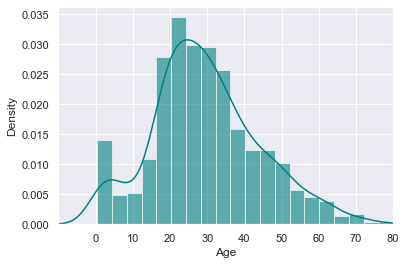

In [296]:
ax = train_df["Age"].hist(bins=20, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10, train_df["Age"].max())
#ax.axes.xaxis.set_ticklabels([])
plt.xticks(np.arange(0, train_df["Age"].max()+10, 10.0))
plt.show()

In [297]:
print('Age - median = %3.2f' %train_df['Age'].median())
print('Age - mean = %3.2f' %train_df['Age'].mean())

Age - median = 28.00
Age - mean = 29.70


Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
/t S    644
C    168
Q     77
Name: Embarked, dtype: int64


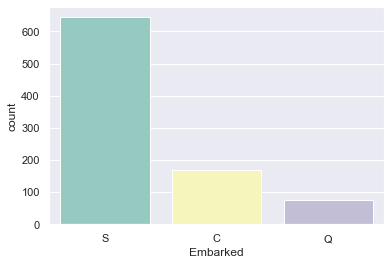

In [298]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print('/t',train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set3')
plt.show()

In [299]:
print('The most common boarding port of embarkation is %s.' %train_df['Embarked'].value_counts().idxmax())

The most common boarding port of embarkation is S.


### <font color='orange'>Correction of missing values</font>

In [300]:
# Cabin - ignore
# Age - median
# Embarked - max

train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [301]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [346]:
train_data.head()
train_data['Age'].value_counts()

28.000    202
24.000     30
22.000     27
18.000     26
19.000     25
         ... 
55.500      1
70.500      1
66.000      1
23.500      1
0.420       1
Name: Age, Length: 88, dtype: int64

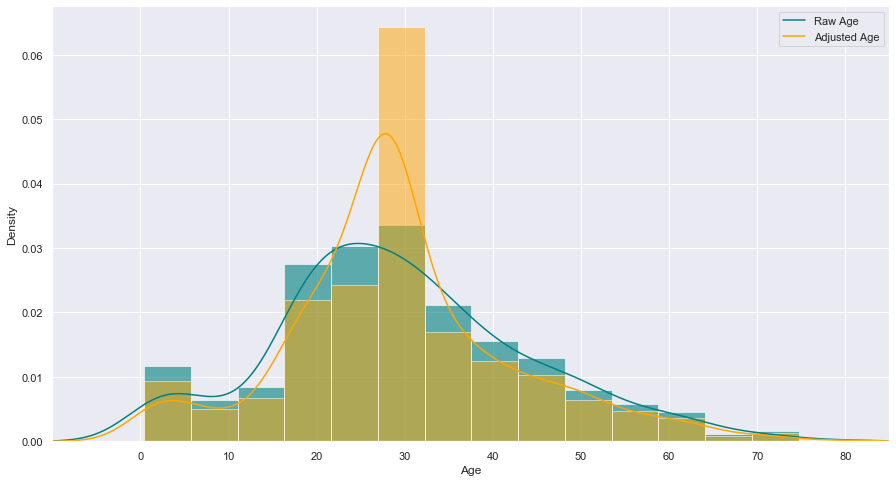

In [345]:
plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.xticks(np.arange(0, train_df["Age"].max()+10, 10.0))
plt.show()

### <font color='orange'>Multicollinearity</font>

In [304]:
import seaborn as sns
 
cm = sns.light_palette("red", as_cmap=True)
 
corr = train_df.corr()
corr.style.background_gradient(cmap='YlGnBu')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


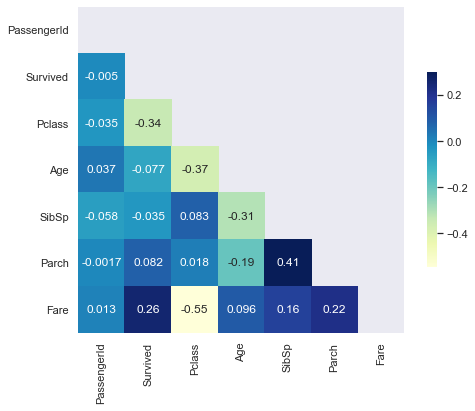

In [305]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"): #darkgrid, whitegrid, dark, white, ticks
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap="YlGnBu",
                     cbar_kws={"shrink": .6})

In [306]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [307]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,A/5 21171,7.250,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,PC 17599,71.283,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,STON/O2. 3101282,7.925,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,113803,53.100,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000,373450,8.050,S,1


### <font color='orange'>Create categorical variables</font>

In [308]:
#create categorical variables and drop some variables

training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])

training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.000,7.250,0,0,0,1,0,0,1,1
1,1,38.000,71.283,0,1,0,0,1,0,0,0
2,1,26.000,7.925,1,0,0,1,0,0,1,0
3,1,35.000,53.100,0,1,0,0,0,0,1,0
4,0,35.000,8.050,1,0,0,1,0,0,1,1


### <font color='orange'>Apply the same changes to the test data</font>

In [320]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [321]:
print('Test -> dipicate rows -> {}'.format(test_df.duplicated().sum()))

Test -> dipicate rows -> 0


In [322]:
stat = pd.DataFrame(test_df.isnull().sum(), columns=['Test_IsNull'])
stat['Test_IsNull%'] = 100*stat['Test_IsNull']/test_df.shape[0]
stat.sort_values(by=['Test_IsNull'], inplace=True, ascending=False)
stat.loc[stat['Test_IsNull'] != 0]

,Test_IsNull,Test_IsNull%
Cabin,327,78.230
Age,86,20.574
Fare,1,0.239


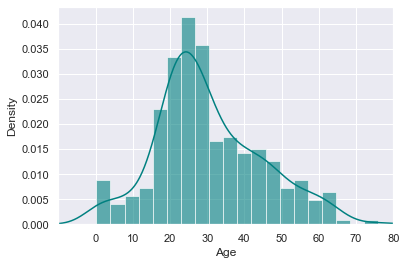

In [323]:
ax = test_df["Age"].hist(bins=20, density=True, stacked=True, color='teal', alpha=0.6)
test_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10, test_df["Age"].max())
#ax.axes.xaxis.set_ticklabels([])
plt.xticks(np.arange(0, test_df["Age"].max()+10, 10.0))
plt.show()

In [324]:
print('Age - median = %3.2f' %test_df['Age'].median())
print('Age - mean = %3.2f' %test_df['Age'].mean())

Age - median = 27.00
Age - mean = 30.27


In [325]:
test_df['Fare'].head()

0    7.829
1    7.000
2    9.688
3    8.662
4   12.287
Name: Fare, dtype: float64

In [326]:
# Cabin - ignore
# Age - median
# Fare - median

test_data = test_df.copy()
test_data["Age"].fillna(test_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(test_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

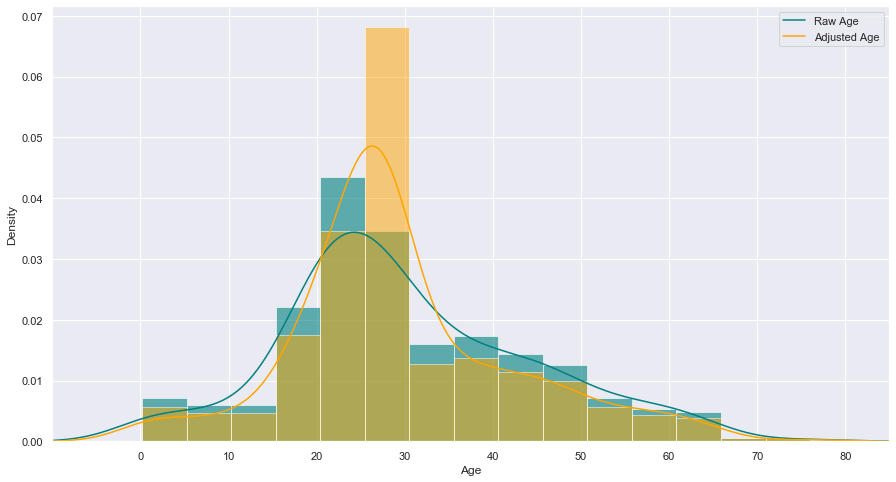

In [411]:
plt.figure(figsize=(15,8))
ax = test_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
test_df["Age"].plot(kind='density', color='teal')
ax = test_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
test_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.xticks(np.arange(0, test_df["Age"].max()+10, 10.0))
plt.show()

In [328]:
test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.500,7.829,1,0,0,1,0,1,0,1
1,47.000,7.000,0,0,0,1,0,0,1,0
2,62.000,9.688,1,0,1,0,0,1,0,1
3,27.000,8.662,1,0,0,1,0,0,1,1
4,22.000,12.287,0,0,0,1,0,0,1,0


### <font color='orange'>Exploratory Data Analysis - Age</font>

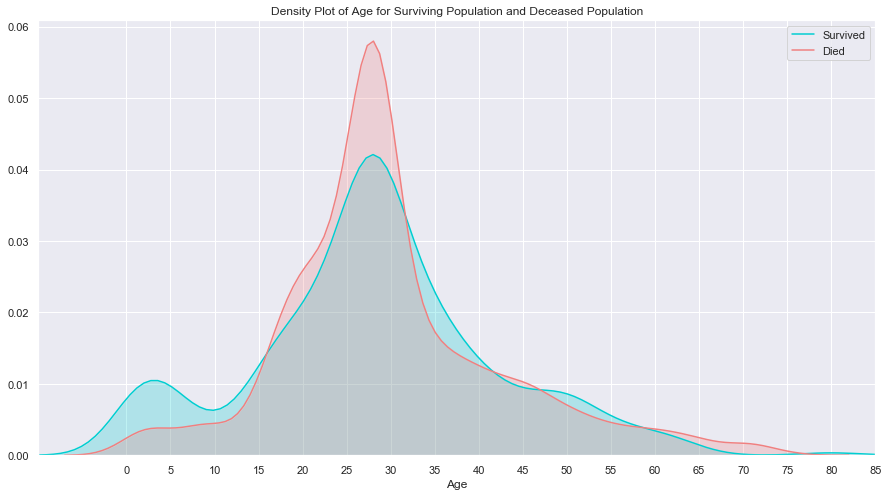

In [353]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.xticks(np.arange(0,final_train["Age"].max()+10, 5.0))
plt.show()

In [394]:
avg_survival_byage = final_train[["Age", "Survived"]]
bins_age=[]
for i in range(0,90,2):
    bins_age.append(i)
avg_survival_byage['Age_5'] = pd.cut(x=avg_survival_byage['Age'], bins=bins_age)
avg_survival_byage = avg_survival_byage[["Age_5", "Survived"]].groupby(['Age_5'],sort=True,as_index=False).mean()
avg_survival_byage.head()

,Age_5,Survived
0,"(0, 2]",0.625
1,"(2, 4]",0.750
2,"(4, 6]",0.857
3,"(6, 8]",0.429
4,"(8, 10]",0.200


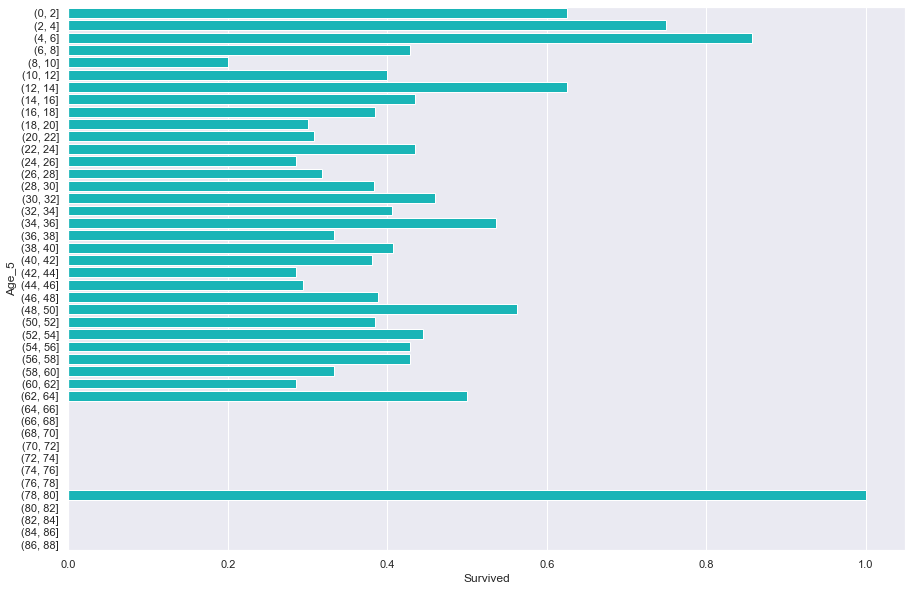

In [408]:
plt.figure(figsize=(15,10))
g = sns.barplot(x='Survived', y='Age_5', data=avg_survival_byage, color="darkturquoise")
plt.show()

In [397]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

### <font color='orange'>Exploratory Data Analysis - Fare</font>

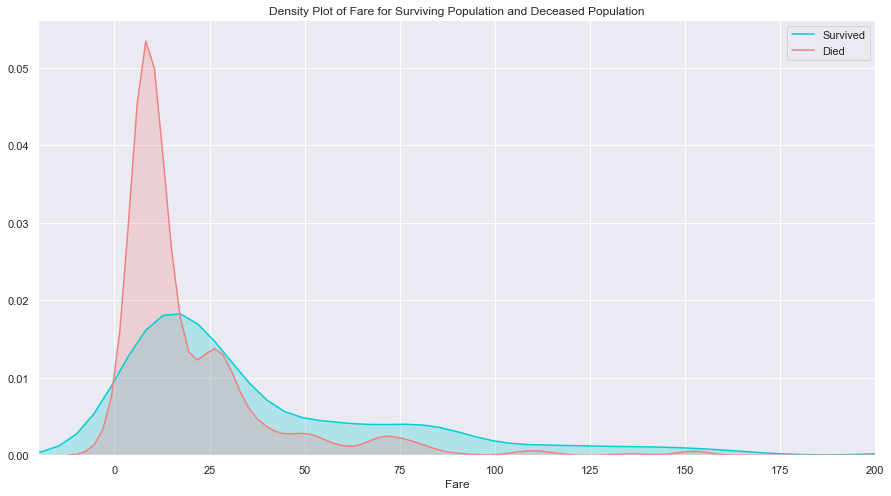

In [417]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
#plt.xticks(np.arange(0,final_train["Fare"].max()+10, 5.0))
plt.show()

### <font color='orange'>Exploratory Data Analysis - Passenger Class</font>

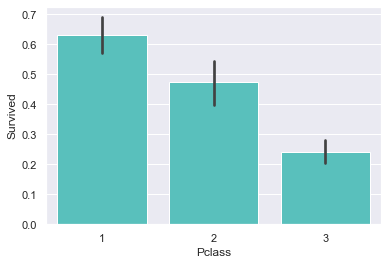

In [424]:
sns.barplot('Pclass', 'Survived', data=train_df, color="mediumturquoise")
plt.show()

### <font color='orange'>Exploratory Data Analysis - Embarked Port</font>

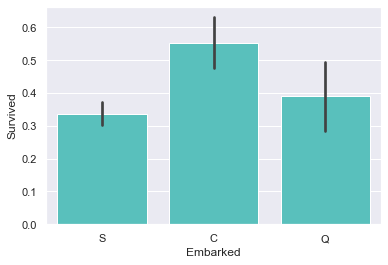

In [425]:
sns.barplot('Embarked', 'Survived', data=train_df, color="mediumturquoise")
plt.show()

### <font color='orange'>Exploratory Data Analysis - Traveling Alone vs. With Family</font>

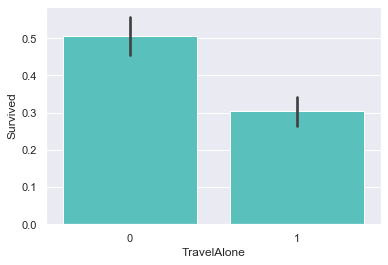

In [426]:
sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")
plt.show()

### <font color='orange'>Exploratory Data Analysis - Sex</font>

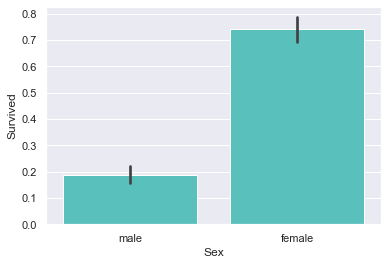

In [427]:
sns.barplot('Sex', 'Survived', data=train_df, color="mediumturquoise")
plt.show()

## <font color='green'>Feature selection</font>

### <font color='brawn'>RFE - Recursive feature elimination</font>

In [474]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']

model = LogisticRegression()

rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
#print('Selected features: %s' % list(X.columns[rfe.support_]))

In [475]:
rfe_features = pd.DataFrame(cols, columns=['Features'])
rfe_features_selected = pd.DataFrame(X.columns[rfe.support_], columns=['Features'])
rfe_features_selected = pd.merge(rfe_features,rfe_features_selected, on='Features', how='outer', indicator=True)

rfe_features_selected.loc[rfe_features_selected['_merge'] == 'both', 'Selected features'] = rfe_features_selected['Features']
rfe_features_selected.loc[rfe_features_selected['_merge'] != 'both', 'Selected features'] = ''

rfe_features_selected.drop('_merge', axis=1, inplace=True)
rfe_features_selected

,Features,Selected features
0,Age,Age
1,Fare,
2,TravelAlone,TravelAlone
3,Pclass_1,Pclass_1
4,Pclass_2,Pclass_2
5,Embarked_C,Embarked_C
6,Embarked_S,Embarked_S
7,Sex_male,Sex_male
8,IsMinor,IsMinor


### <font color='brawn'>RFECV - Recursive feature elimination with cross-validation</font>

In [477]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

Optimal number of features: 9
Selected features: ['Age', 'Fare', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


In [482]:
rfecv_features = pd.DataFrame(cols, columns=['Features'])
rfecv_features_selected = pd.DataFrame(X.columns[rfecv.support_], columns=['Features'])
rfecv_features_selected = pd.merge(rfecv_features,rfecv_features_selected, on='Features', how='outer', indicator=True)

rfecv_features_selected.loc[rfecv_features_selected['_merge'] == 'both', 'Selected features'] = rfecv_features_selected['Features']
rfecv_features_selected.loc[rfecv_features_selected['_merge'] != 'both', 'Selected features'] = ''

rfecv_features_selected.drop('_merge', axis=1, inplace=True)
rfecv_features_selected

,Features,Selected features
0,Age,Age
1,Fare,Fare
2,TravelAlone,TravelAlone
3,Pclass_1,Pclass_1
4,Pclass_2,Pclass_2
5,Embarked_C,Embarked_C
6,Embarked_S,Embarked_S
7,Sex_male,Sex_male
8,IsMinor,IsMinor


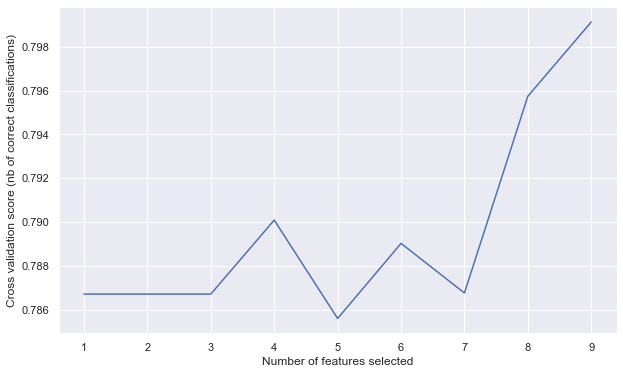

In [480]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [470]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

corr = X.corr()

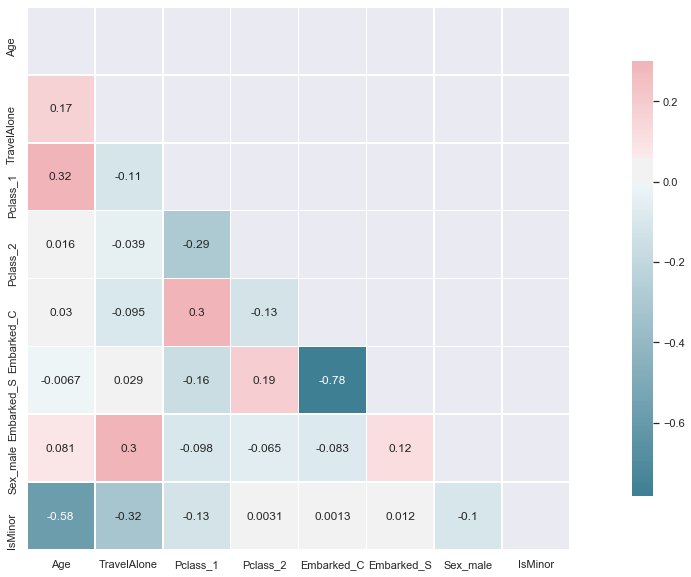

In [481]:
#sns.set(style="ticks")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(22, 10))
cmap = sns.diverging_palette(580, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0.03,annot=True,
            square=True, linewidths=.9, cbar_kws={"shrink": 0.8})

## <font color='green'>Model evaluation based on simple train/test split using (sklearn) 
</font>

In [552]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

X = final_train[Selected_features]
y = final_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [553]:
# check classification scores of logistic regression
logreg = LogisticRegression() #(fit_intercept = False)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility> 0.95

# AUC - Compute Area Under the Curve 

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.838


[[90 10]
 [29 50]]
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       100
           1       0.83      0.63      0.72        79

    accuracy                           0.78       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.78      0.78       179



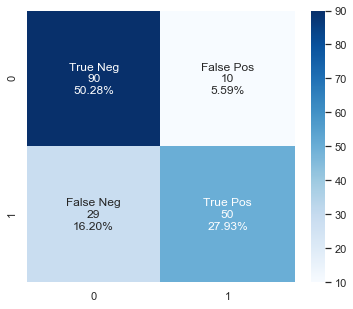

In [554]:
import sklearn.metrics as skm
import numpy as np

# compute confusion_matrix
cm = skm.confusion_matrix(y_test, y_pred)
print(cm)

# compute classification 
print(skm.classification_report(y_test, y_pred))
#report = skm.classification_report(y_test, y_pred, output_dict=True)
#print(report)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

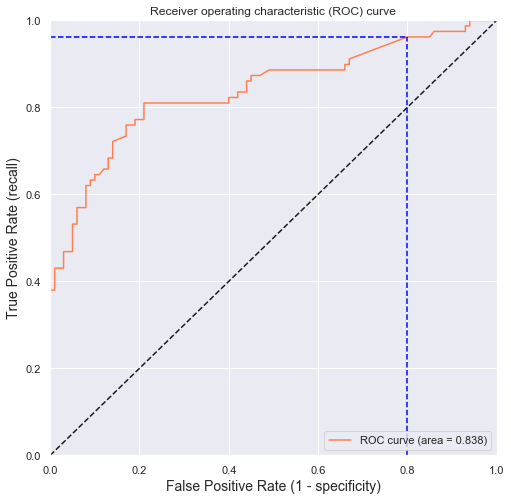

Using a threshold of 0.070 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [555]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + 
      "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [558]:
print('Coef:{}'.format(logreg.coef_))
print('Intercept:{}'.format(logreg.intercept_))

Coef:[[-0.02724458  0.00801238  2.11844974  1.25789967  0.05156777 -0.44100086
  -2.52478998  0.5017654 ]]
Intercept:[1.14043073]


## <font color='green'>Model evaluation based on simple train/test split using (statsmodels) 
</font>

In [544]:
predictors = X_train
predictors['intercept'] = 1
#predictors.head()

In [543]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,predictors)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.433192
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.342     
Dependent Variable: Survived         AIC:              634.8659  
Date:               2020-04-30 22:19 BIC:              675.9786  
No. Observations:   712              Log-Likelihood:   -308.43   
Df Model:           8                LL-Null:          -468.94   
Df Residuals:       703              LLR p-value:      1.3754e-64
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Age          -0.0291    0.0106   -2.7506  0.0059  -0.0499  -0.0084
TravelAlone   0.0590    0.2213    0.2664  0.7899  -0.3748   0.

## <font color='green'>Model evaluation based on K-fold cross-validation using cross_val_score() function</font>

In [593]:
logreg = LogisticRegression()

# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.796
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850


## <font color='green'>Model evaluation based on K-fold cross-validation using cross_validate() function</font>

In [572]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()),
                         return_estimator=True, return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.796 (+/-0.024)
LogisticRegression average log_loss: 0.454 (+/-0.037)
LogisticRegression average auc: 0.850 (+/-0.028)


In [586]:
#results

In [594]:
#for model in results['estimator']:
 #   print(model.classes_)
 #  print(model.score(X,y))
 #   print(model.intercept_)
 #   print(model.coef_)